# Prioritized Experience Replay

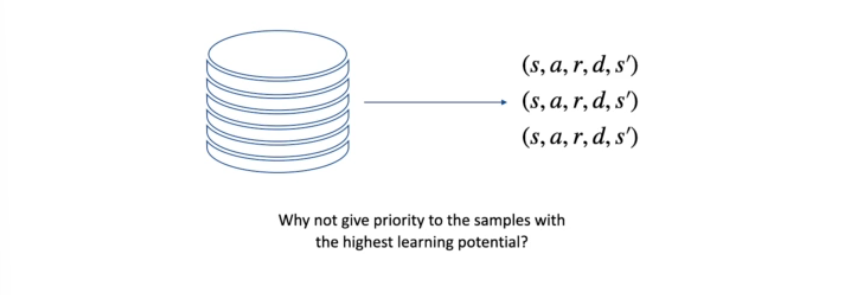

> __We are going to modify our buffer to include a certain priority for each of the samples of experience.__ of course that the priority'll changes over the timn..

> The higher the priority of a sample of experience, the higher will be the probability of choosing it.

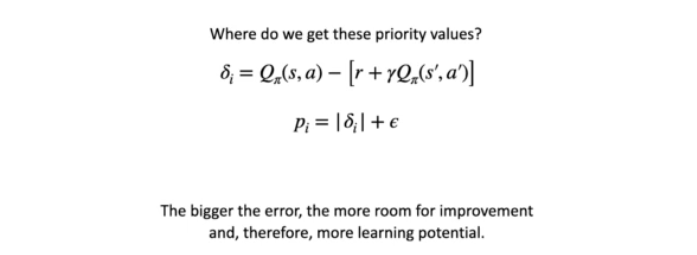

> __The bigger the TD error, the more room for improvment, therefore more learning potential__

Let's improve even more the Q-learning.

This time we are going to change our replay buffer to select its samples based on their learning potential.

In [ ]:
!apt-get install -y xvfb

!pip install pygame gym==0.18 stable-baselines3 pytorch-lightning==1.6.0 pyvirtualdisplay

!pip install git+https://github.com/GrupoTuring/PyGame-Learning-Environment
!pip install git+https://github.com/lusob/gym-ple

#### Setup virtual display

In [ ]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [ ]:
import copy
import torch
import random
import gym
import gym_ple
import matplotlib

import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import TransformObservation

from stable_baselines3.common.atari_wrappers import MaxAndSkipEnv, WarpFrame


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [ ]:
# Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb#scrollTo=gKc1FNhKiVJX

def display_video(frames, framerate=30):
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

#### Create the Deep Q-Network

In [ ]:

class DQN(nn.Module):
    """
    Deep Q-Network (DQN) with a convolutional neural network (CNN) architecture.

    Parameters:
        - hidden_size (int): Size of the hidden layer in the fully connected part of the network.
        - obs_shape (tuple): Shape of the input observations (channels, height, width).
        - n_actions (int): Number of possible actions.

    """
    def __init__(self, hidden_size, obs_shape, n_actions):
        super().__init__()

        # Convolutional layers for feature extraction
        self.conv = nn.Sequential(
            nn.Conv2d(obs_shape[0], 64, kernel_size=3),
            nn.MaxPool2d(kernel_size=4),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.MaxPool2d(kernel_size=4),
            nn.ReLU(),
        )

        # Calculate the size of the flattened output from convolutional layers
        conv_out_size = self._get_conv_out(obs_shape)

        # Fully connected layers for value and advantage streams
        self.head = nn.Sequential(
            nn.Linear(conv_out_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
        )

        # Advantage stream
        self.fc_adv = nn.Linear(hidden_size, n_actions)

        # Value stream
        self.fc_value = nn.Linear(hidden_size, 1)

    def _get_conv_out(self, shape):
        """
        Calculate the size of the flattened output from convolutional layers.

        Parameters:
            - shape (tuple): Shape of the input observations (channels, height, width).

        Returns:
            - int: Size of the flattened output.
              - e.g: (64, height, width) -> [f1,f2,f3] -> size = 3.

        """
        conv_out = self.conv(torch.zeros(1, *shape))
        return int(np.prod(conv_out.size()))

    def forward(self, x):
        """
        Forward pass through the DQN.

        Parameters:
            - x (torch.Tensor): Input observations.

        Returns:
            - torch.Tensor: Q-values for each action.

        """
        x = self.conv(x.float()).view(x.size()[0], -1)  # Flatten the output of convolutional layers
        x = self.head(x)  # Fully connected layers for value and advantage streams
        adv = self.fc_adv(x)  # Advantage stream
        value = self.fc_value(x)  # Value stream
        return value + adv - torch.mean(adv, dim=1, keepdim=True)

#### Create the policy

In [ ]:
def epsilon_greedy(state, env, net, epsilon=0.0):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    state = torch.tensor([state]).to(device)
    q_values = net(state)
    _, action = torch.max(q_values, dim=1)
    action = int(action.item())
  return action

#### Create the replay buffer with __Prioritized Experience Replay__

In [ ]:
class ReplayBuffer:

  # Constructor.
  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity) # initial memory
    self.priorities = deque(maxlen=capacity) # initial priorities
    self.capacity = capacity # size of transitions and their priorities

    # will decide how much should emphasize samples of experience from
    # our deck that have a high learning potential.
    # - alpha = 1: we have to select the samples of experience from our buffer,
    #   giving the highest priority to the ones with the highest learning potential.
    # - alpha = 0: each experience have the same probability to be chosen.
    self.alpha = 1.0

    # controls how much the sampling distribution should be adjusted to
    # account for the non-uniform sampling probabilities introduced
    # by prioritized experience replay.
    # - A value of 0.5 indicates a balanced correction. As training progresses,
    #   beta may be updated to give more or less emphasis to the correction.
    # - higher beta means that the network will see those samples (PER)
    #   more often than it will when it faces the environment.
    self.beta = 0.5
    self.max_priority = 0.0

  # __len__
  def __len__(self):
    return len(self.buffer)

  # Append.
  def append(self, experience):
    """
    Add new sample and its priority.
    """
    self.buffer.append(experience)
    self.priorities.append(self.max_priority)

  # Update.
  def update(self, index, priority):
    """
    Update the priority of a transition.

    Parameters
    -----------
    - `index`: the location of the sample (of the transition)
    - `priority`: the new value of the priority that we want to update.
    """
    # set the max priority id need (we need to know what is the transition
    # that have the maximum priority).
    if priority > self.max_priority:
      self.max_priority = priority

    # update the priority of that transition.
    self.priorities[index] = priority

  # Sample.
  def sample(self, batch_size):
    """

    """
    # initial array of the priorities
    prios = np.array(self.priorities, dtype=np.float64) + 1e-4
    # raise the alpha on the priorities
    prios = prios ** self.alpha
    # compute the probabilities of each priority (of selecting each sample)
    probs = prios / prios.sum()

    # These weights will correct the change in distribution of the samples
    # that we will observe.
    # beta is used to adjust the weights assigned to each sample during the
    # sampling process.
    weights = (self.__len__() * probs) ** -self.beta
    # make sure all the weigths between [0,1]
    weights = weights / weights.max()

    # from range of `__len__()`,
    #  choose randon `batch_size` samples with pribability of `probs`
    idx = random.choices(range(self.__len__()), weights=probs, k=batch_size)
    # create list of items, each element'll be an experience.
    sample = [(i, weights[i], *self.buffer[i]) for i in idx]
    return sample # (the_sample_index, its_weigth, ( its_transition ) )


In [ ]:
class RLDataset(IterableDataset):
  """
  An iterable dataset
  """
  def __init__(self, buffer, sample_size=400):
    self.buffer = buffer
    self.sample_size = sample_size

  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

#### Create the environment

In [ ]:
# Calculate the running mean and std more efficiently,
# for normalize the observation and the rewards.
# artificial neutral networks loves normalize data.


class RunningMeanStd:
    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, epsilon=1e-4, shape=()):
        self.mean = np.zeros(shape, "float64")
        self.var = np.ones(shape, "float64")
        self.count = epsilon

    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        self.update_from_moments(batch_mean, batch_var, batch_count)

    def update_from_moments(self, batch_mean, batch_var, batch_count):
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count
        )


def update_mean_var_count_from_moments(
    mean, var, count, batch_mean, batch_var, batch_count
):
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + np.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count


class NormalizeObservation(gym.core.Wrapper):
    def __init__(
        self,
        env,
        epsilon=1e-8,
    ):
        super().__init__(env)
        self.num_envs = getattr(env, "num_envs", 1)
        self.is_vector_env = getattr(env, "is_vector_env", False)
        if self.is_vector_env:
            self.obs_rms = RunningMeanStd(shape=self.single_observation_space.shape)
        else:
            self.obs_rms = RunningMeanStd(shape=self.observation_space.shape)
        self.epsilon = epsilon

    def step(self, action):
        obs, rews, dones, infos = self.env.step(action)
        if self.is_vector_env:
            obs = self.normalize(obs)
        else:
            obs = self.normalize(np.array([obs]))[0]
        return obs, rews, dones, infos

    def reset(self, **kwargs):
        return_info = kwargs.get("return_info", False)
        if return_info:
            obs, info = self.env.reset(**kwargs)
        else:
            obs = self.env.reset(**kwargs)
        if self.is_vector_env:
            obs = self.normalize(obs)
        else:
            obs = self.normalize(np.array([obs]))[0]
        if not return_info:
            return obs
        else:
            return obs, info

    def normalize(self, obs):
        self.obs_rms.update(obs)
        return (obs - self.obs_rms.mean) / np.sqrt(self.obs_rms.var + self.epsilon)


class NormalizeReward(gym.core.Wrapper):
    def __init__(
        self,
        env,
        gamma=0.99,
        epsilon=1e-8,
    ):
        super().__init__(env)
        self.num_envs = getattr(env, "num_envs", 1)
        self.is_vector_env = getattr(env, "is_vector_env", False)
        self.return_rms = RunningMeanStd(shape=())
        self.returns = np.zeros(self.num_envs)
        self.gamma = gamma
        self.epsilon = epsilon

    def step(self, action):
        obs, rews, dones, infos = self.env.step(action)
        if not self.is_vector_env:
            rews = np.array([rews])
        self.returns = self.returns * self.gamma + rews
        rews = self.normalize(rews)
        self.returns[dones] = 0.0
        if not self.is_vector_env:
            rews = rews[0]
        return obs, rews, dones, infos

    def normalize(self, rews):
        self.return_rms.update(self.returns)
        return rews / np.sqrt(self.return_rms.var + self.epsilon)

In [ ]:
env = gym_ple.make("FlappyBird-v0")

In [ ]:
obs = env.reset()
obs.shape

In [ ]:
env.observation_space, env.action_space

In [ ]:
for i in range(20):
  obs, rew, done, info = env.step(env.action_space.sample())

plt.imshow(obs)

In [ ]:
env = MaxAndSkipEnv(env, skip=2)

In [ ]:
obs = env.reset()

for i in range(10):
  obs, _, _, _ = env.step(env.action_space.sample())

In [ ]:
type(obs), obs.shape

In [ ]:
plt.imshow(obs)

In [ ]:
env = WarpFrame(env, height=42, width=42)

In [ ]:
obs = env.reset()

for i in range(10):
  obs, _, _, _ = env.step(env.action_space.sample())

In [ ]:
type(obs), obs.shape

In [ ]:
plt.imshow(obs.squeeze(), cmap='gray_r')

In [ ]:
obs.min(), obs.max()

In [ ]:
env = TransformObservation(env, lambda x: x.swapaxes(-1, 0))
env.observation_space = gym.spaces.Box(low=0, high=255, shape=(1, 42, 42), dtype=np.float32)

In [ ]:
obs = env.reset()

for i in range(10):
  obs, _, _, _ = env.step(env.action_space.sample())

In [ ]:
obs.shape

In [ ]:
def create_environment(env_name):
  env = gym_ple.make(env_name)
  env = MaxAndSkipEnv(env, skip=2)
  env = WarpFrame(env, height=42, width=42)
  env = TransformObservation(env, lambda x: x.swapaxes(-1, 0))
  env.observation_space = gym.spaces.Box(low=0, high=255, shape=(1, 42, 42), dtype=np.float32)
  env = NormalizeObservation(env)
  env = NormalizeReward(env)
  return env

#### Create the Deep Q-Learning algorithm with Prioritized Experience Replay


In [ ]:
class DeepQLearning(LightningModule):
  """
  Implementation of Deep Q-Learning with Prioritized Experience Replay

Parameters
----------
- `env_name`: Name of the environment.
- `policy`: Action selection policy function (default is epsilon_greedy).
- `capacity`: Capacity of the replay buffer.
- `batch_size`: Batch size for training.
- `lr`: Learning rate for the Q-network optimizer.
- `hidden_size`: Size of the hidden layer in the Q-network.
- `gamma`: Discount factor for future rewards.
- `loss_fn`: Loss function for training the Q-network.
- `optim`: Optimizer for the Q-network.
- `eps_start`: Initial value of epsilon in epsilon-greedy exploration.
- `eps_end`: Final value of epsilon in epsilon-greedy exploration.
- `eps_last_episode`: Episode number at which epsilon reaches its final value.
- `samples_per_epoch`: Number of initial samples to fill the replay buffer.
- `sync_rate`: Frequency at which to sync the target Q-network with the Q-network.
- `a_start`: Initial value of parameter 'a' for prioritized experience replay.
- `a_end`: Final value of parameter 'a' for prioritized experience replay.
- `a_last_episode`: Episode number at which parameter 'a' reaches its final value.
- `b_start`: Initial value of parameter 'b' for prioritized experience replay.
- `b_end`: Final value of parameter 'b' for prioritized experience replay.
- `b_last_episode`: Episode number at which parameter 'b' reaches its final value.
  """
  # Initialize.
  def __init__(self, env_name, policy=epsilon_greedy, capacity=100_000,
               batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99,
               loss_fn=F.smooth_l1_loss, optim=AdamW, eps_start=1.0, eps_end=0.15,
               eps_last_episode=100, samples_per_epoch=1_000, sync_rate=10,
               a_start=0.5, a_end=0.0, a_last_episode=100,
               b_start=0.4, b_end=1.0, b_last_episode=100):

    super().__init__()
    self.env = create_environment(env_name) # create environment

    obs_size = self.env.observation_space.shape # Input shape: state
    n_actions = self.env.action_space.n # Output shape: action

    # Initial Q-netwoek
    self.q_net = DQN(hidden_size, obs_size, n_actions)
    # Initial Target-Q-netwoek
    self.target_q_net = copy.deepcopy(self.q_net)

    # Set the policy
    self.policy = policy
    # Initial replay buffer
    self.buffer = ReplayBuffer(capacity=capacity)

    self.save_hyperparameters()

    # Generate samples (experiences) for fill the memory with initial transitions.
    while len(self.buffer) < self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in experience buffer. Filling...")
      self.play_episode(epsilon=self.hparams.eps_start)

  @torch.no_grad()
  def play_episode(self, policy=None, epsilon=0.):
    """
    Play epicode function.

    Use to generate sample (experiences) for fill and update the memory.
    """
    state = self.env.reset()
    done = False

    while not done:
      if policy:
        action = policy(state, self.env, self.q_net, epsilon=epsilon)
      else:
        action = self.env.action_space.sample()

      next_state, reward, done, info = self.env.step(action)
      exp = (state, action, reward, done, next_state)
      self.buffer.append(exp)
      state = next_state

  # Forward.
  def forward(self, x):
    return self.q_net(x)

  # Configure optimizers.
  def configure_optimizers(self):
    q_net_optimizer = self.hparams.optim(self.q_net.parameters(), lr=self.hparams.lr)
    return [q_net_optimizer]

  # Create dataloader.
  def train_dataloader(self):
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=self.hparams.batch_size
    )
    return dataloader


  # Training step.
  def training_step(self, batch, batch_idx):
    """
    Execute a training step of Deep Q-Learning with Prioritized Experience Replay.

    Parameters:
        - `batch` (tuple): A batch of experiences sampled from the replay buffer.
          It contains indices, weights, states, actions, rewards, dones, and next_states.
        - `batch_idx` (int): Index of the current batch.

    Returns:
        - torch.Tensor: The computed loss during the training step.

    """"
    # Unpack
    indices, weights, states, actions, rewards, dones, next_states = batch

    # Ensure proper shape for weights, actions, rewards, and dones:
    # [[w],[w],[w],...]
    # ....
    # [[d],[d],[d],...]
    weights = weights.unsqueeze(1)
    actions = actions.unsqueeze(1)
    rewards = rewards.unsqueeze(1)
    dones = dones.unsqueeze(1)

    # 1. Compute Q-values for the current states and actions
    # --> will return [Q(s,a), Q(s,a), ...]
    state_action_values = self.q_net(states).gather(1, actions)

    # 2. Compute Q-values for the next states and best actions
    #    using the Target-Q-network
    with torch.no_grad():
      # For the next states, give me the BEST actions (by Q-network)
      _, next_actions = self.q_net(next_states).max(dim=1, keepdim=True)
      # By the Target-Q-Netwoek, compute Q(s',a*)
      # its the value of the next state with the best action.
      # --> will return [Q(s',a*), Q(s',a*), ...]
      next_action_values = self.target_q_net(next_states).gather(1, next_actions)
      next_action_values[dones] = 0.0

    # 3. Compute the expected Q-values using the Bellman equation
    expected_state_action_values = rewards + self.hparams.gamma * next_action_values

    # 4. Compute the Temporal Difference (TD) errors for prioritized experience replay
    td_errors = (state_action_values - expected_state_action_values).abs().detach()

    # 5. Update priorities in the replay buffer with the TD errors!
    # - the more TD error, the more priority to the experience,
    #   beacuse its mean that there is much more to learn (high potential of learning)
    for idx, e in zip(indices, td_errors):
      # update by sending the location of the experience, and its TD.
      self.buffer.update(idx, e.cpu().item())

    # 6. Compute the loss using the prioritized experience replay weights
    loss = weights * self.hparams.loss_fn(state_action_values, expected_state_action_values, reduction='none')
    loss = loss.mean()

    self.log('episode/Q-Error', loss)
    return loss

  def training_epoch_end(self, training_step_outputs):
    """
    Callback function executed at the end of each training epoch.

    Parameters:
        - `training_step_outputs` (list): List of outputs from each training step during the epoch.

    """
    # Calculate the exploration rate epsilon, alpha, and beta decay schedules
    epsilon = max(
        self.hparams.eps_end,
        self.hparams.eps_start - self.current_epoch / self.hparams.eps_last_episode
    )
    alpha = max(
        self.hparams.a_end,
        self.hparams.a_start - self.current_epoch / self.hparams.a_last_episode
    )
    beta = min(
        self.hparams.b_end,
        self.hparams.b_start + self.current_epoch / self.hparams.b_last_episode
    )

    # Update alpha and beta parameters in the replay buffer
    self.buffer.alpha = alpha
    self.buffer.beta = beta

    # Play an episode with the current policy and exploration rate.
    # its for add more new and relevant experience to the memory.
    self.play_episode(policy=self.policy, epsilon=epsilon)
    self.log('episode/Return', self.env.unwrapped.game_state.score())

    # Update the target Q-network with the Q-network at specified intervals.
    if self.current_epoch % self.hparams.sync_rate == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())



#### Purge logs and run the visualization tool (Tensorboard)

In [ ]:
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

#### Train the policy

In [ ]:
algo = DeepQLearning(
    'Snake-v0',
    lr=5e-4,
    hidden_size=512,
    eps_end=0.01,
    eps_last_episode=1_000,
    capacity=10_000,
    gamma=0.9
)

trainer = Trainer(
    gpus=num_gpus,
    max_epochs=3_000,
    log_every_n_steps=1
)

trainer.fit(algo)

#### Check the resulting policy

In [ ]:
env = algo.env
policy = algo.policy
q_net = algo.q_net.cuda()
frames = []

for episode in range(10):
  done = False
  obs = env.reset()
  while not done:
    frames.append(env.render(mode='rgb_array'))
    action = policy(obs, env, q_net)
    obs, _, done, _ = env.step(action)

In [ ]:
display_video(frames)